# Predict Pore Perm from wireline logs

In a *regression* problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where we aim to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This example uses the `tf.keras` API, see [this guide](https://www.tensorflow.org/guide/keras) for details.

In [1]:
# Use seaborn for pairplot
!pip install -q seaborn

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import datetime, os

import sklearn
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, max_error

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [4]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.3.0


### Get the data
First download and import the dataset using pandas:

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
raw_dataset = pd.read_csv('drive/My Drive/1_lewis_research/core_to_wl_merge/Merged_dataset_inner.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
raw_dataset = raw_dataset[raw_dataset.USGS_ID != 'E997']

In [16]:
raw_dataset.columns

Index(['Unnamed: 0', 'depth_ft', 'USGS_ID', 'CAL', 'GR', 'DT', 'SP', 'DENS',
       'PE', 'RESD', 'PHIN', 'PHID', 'PE_smooth', 'GR_smooth', 'Unnamed: 0.1',
       'gz_linear_interp', 'gz_pchip_interp', 'ref_num', 'perm_air_md',
       'perm_klink_md', 'He_por', 'API', 'well_name', 'horz_perm_md',
       'effective_por', 'por_percent', 'stress_swanson_perm_md', 'sample_num',
       'sample', 'Na', 'Na Err', 'Mg', 'Mg Err', 'Al', 'Al Err', 'Si',
       'Si Err', 'P', 'P Err', 'S', 'S Err', 'K', 'K Err', 'Ca', 'Ca Err',
       'Ti', 'Ti Err', 'Cr', 'Cr Err', 'Mn', 'Mn Err', 'Fe', 'Fe Err', 'Co',
       'Co Err', 'Ni', 'Ni Err', 'Cu', 'Cu Err', 'Zn', 'Zn Err', 'Ba',
       'Ba Err', 'ScanTime1', 'LiveTime1', 'ScanTime2', 'LiveTime2'],
      dtype='object')

In [17]:
raw_dataset2 = raw_dataset[['CAL', 'depth_ft', 'GR', 'DT','SP','DENS','PE','RESD',
                            'PHIN','PHID','GR_smooth','PE_smooth', 
                            'He_por', 'perm_klink_md' ]]

In [18]:
dataset = raw_dataset2.copy()
dataset.tail()

,CAL,depth_ft,GR,DT,SP,DENS,PE,RESD,PHIN,PHID,GR_smooth,PE_smooth,He_por,perm_klink_md
12025,0.075490,13378.0,0.638141,0.520073,0.445824,0.502957,0.412641,0.105965,0.509441,0.509441,0.621391,0.387762,NaN,NaN
12026,0.075563,13378.1,0.640420,0.529719,0.448875,0.517158,0.406419,0.094625,0.494742,0.494742,0.624509,0.386998,NaN,NaN
12027,0.075637,13378.2,0.641563,0.538041,0.452058,0.531493,0.399383,0.083399,0.479986,0.479986,0.626826,0.385494,NaN,NaN
12028,0.075710,13378.3,0.642344,0.540492,0.455364,0.546129,0.392456,0.072283,0.465287,0.465287,0.628425,0.383239,NaN,NaN
12029,0.075783,13378.4,0.643518,0.542646,0.458558,0.560063,0.385991,0.061279,0.450531,0.450531,0.629305,0.380287,NaN,NaN


### Clean the data

The dataset contains a few unknown values.

In [19]:
dataset.isna().sum()

CAL               592
depth_ft            0
GR                  0
DT               3347
SP                662
DENS             1386
PE                300
RESD              251
PHIN              251
PHID              251
GR_smooth           0
PE_smooth         349
He_por           5995
perm_klink_md    5995
dtype: int64

Drop those rows to keep this initial tutorial simple.

In [20]:
dataset = dataset.dropna()

The `"Origin"` column is really categorical, not numeric. So convert that to a one-hot:

Note: You can set up the `keras.Model` to do this kind of transformation for you. That's beyond the scope of this tutorial. See the [preprocessing layers](../structured_data/preprocessing_layers.ipynb) or [Loading CSV data](../load_data/csv.ipynb) tutorials for examples.

### Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our models.

In [21]:
train_dataset = dataset.sample(frac=0.75, random_state=0)

test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

Looking at the top row it should be clear that the fuel efficiency (MPG) is a function of all the other parameters. Looking at the other rows it should be clear that they are each functions of eachother.

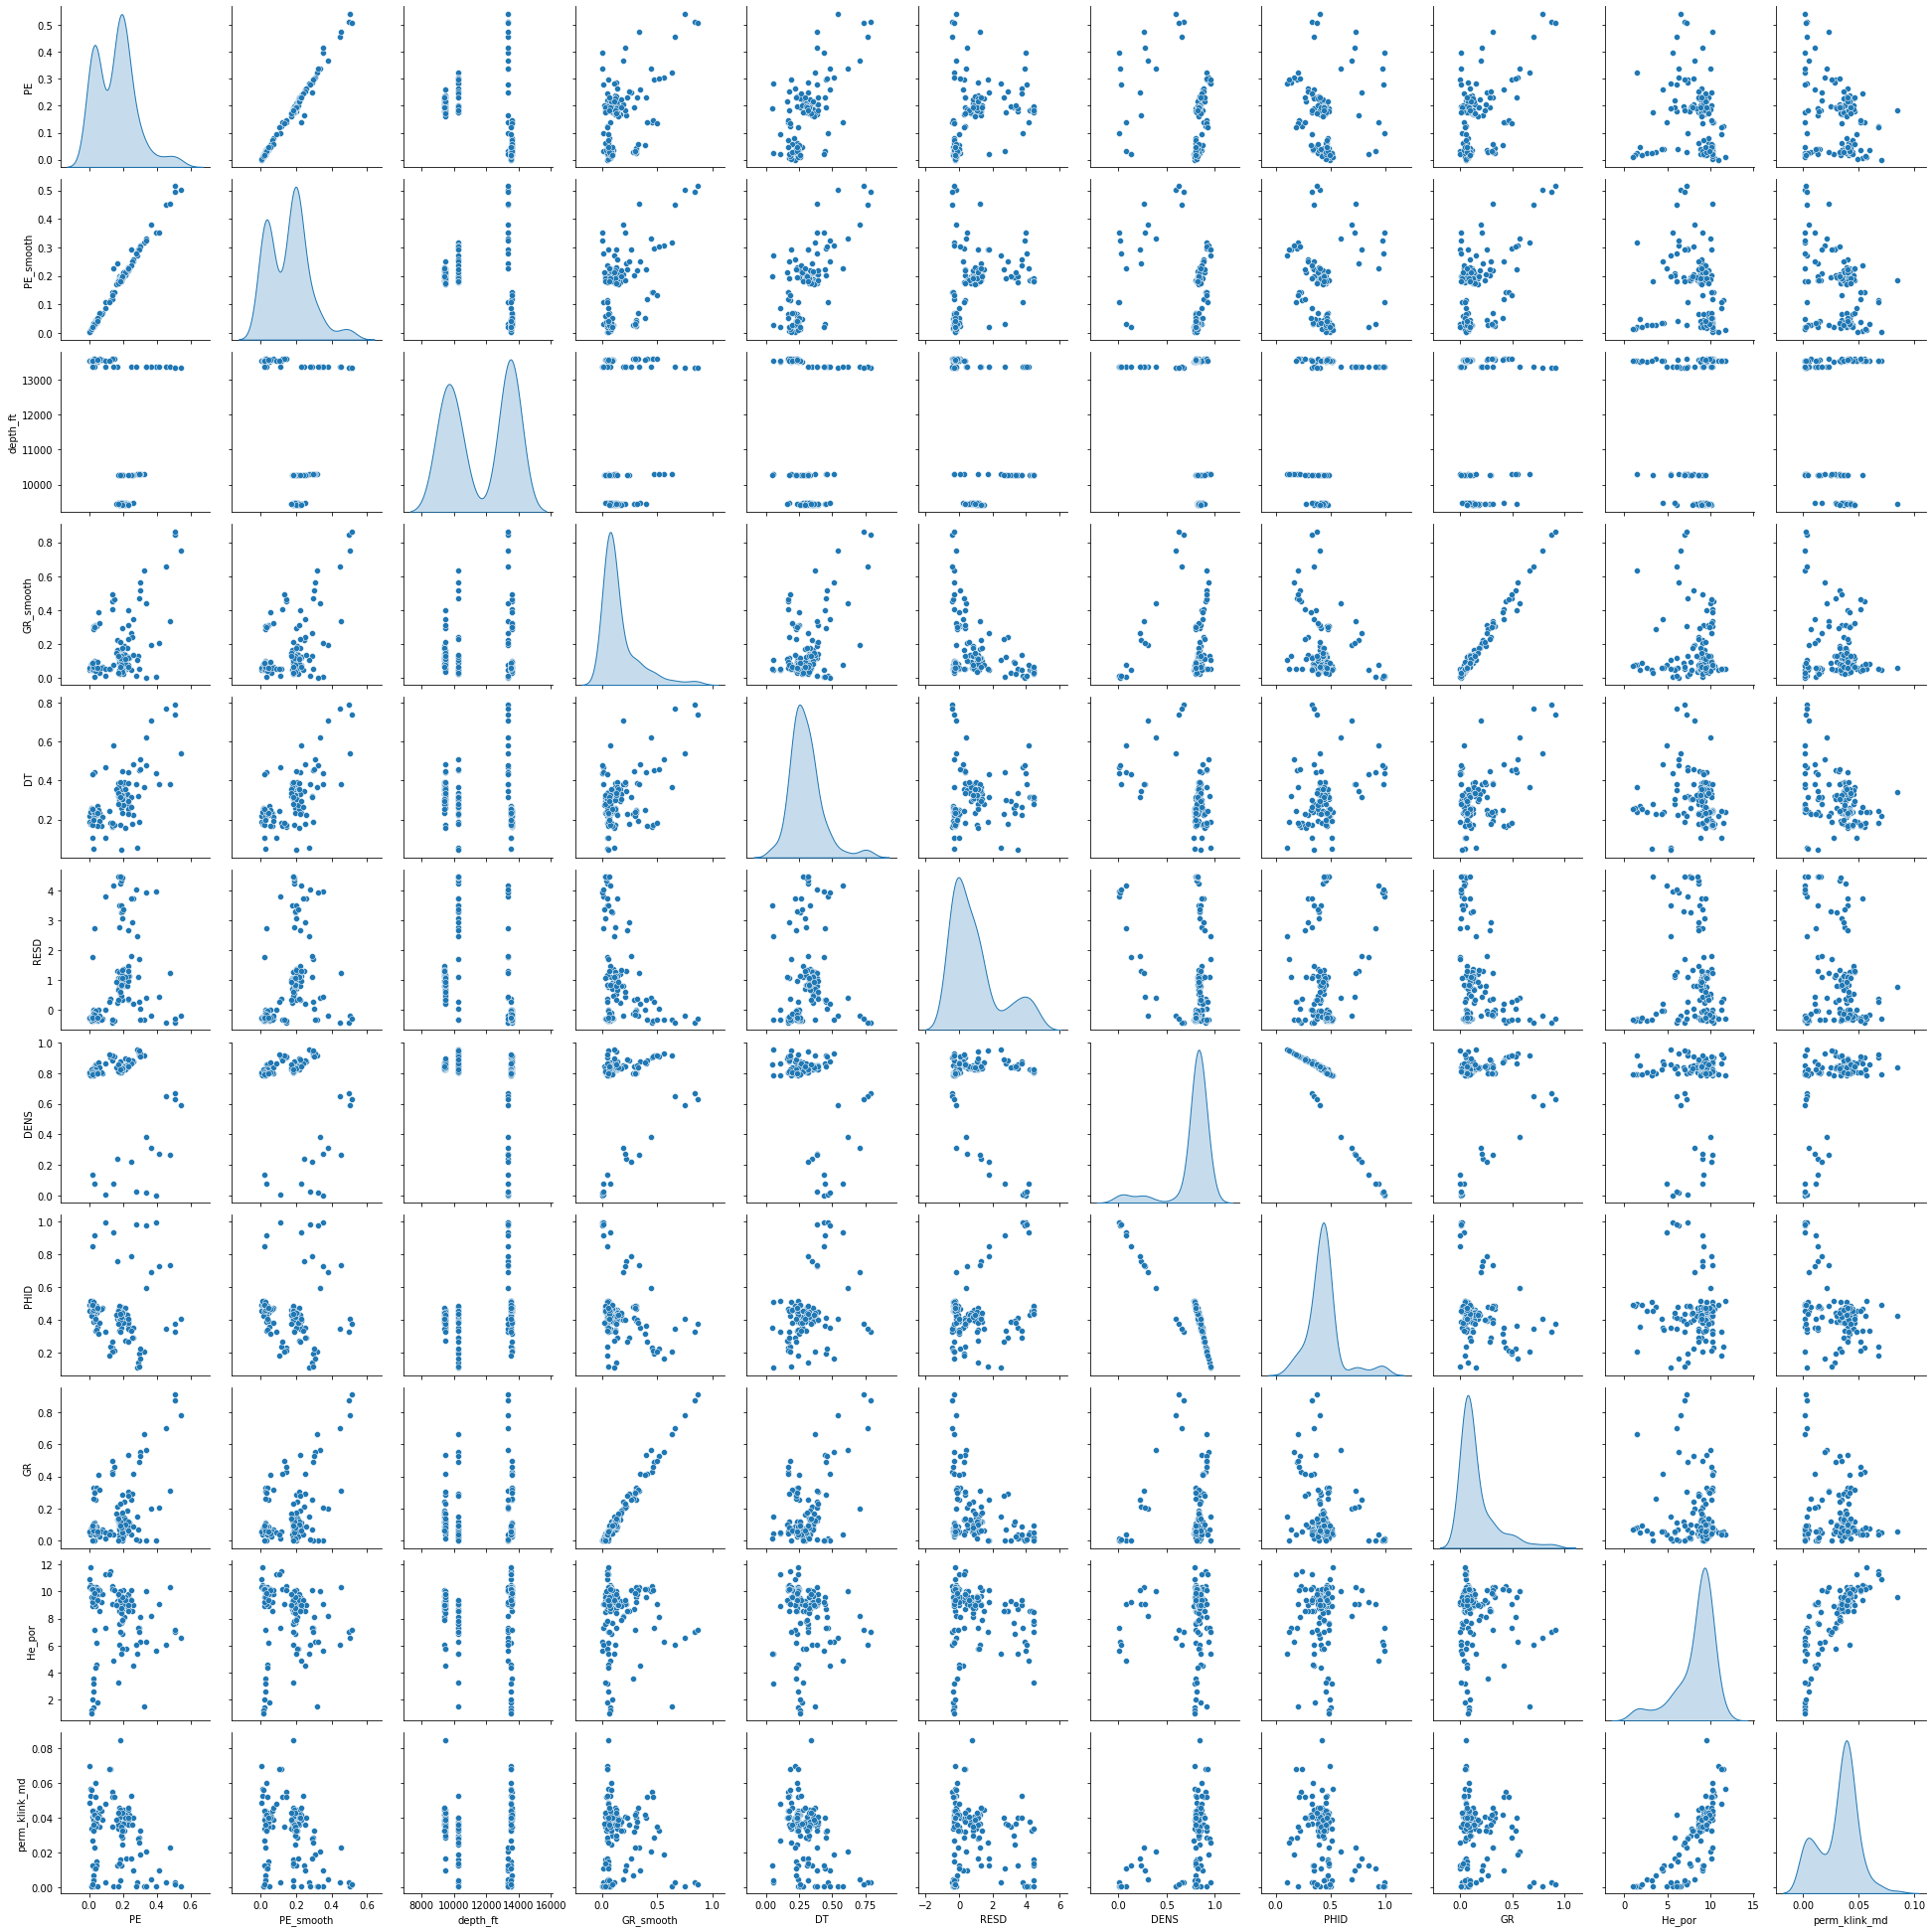

In [22]:
sns.pairplot(train_dataset[['PE', 'PE_smooth','depth_ft', 'GR_smooth', 
                            'DT', 'RESD','DENS','PHID', 'GR',
                            'He_por', 'perm_klink_md']], diag_kind='kde')

Also look at the overall statistics, note how each feature covers a very different range:

In [23]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CAL,142.0,0.168492,0.125881,0.051129,0.067350,0.070568,0.312845,0.350721
depth_ft,142.0,11657.715493,1898.893840,9425.000000,9474.250000,13343.950000,13537.500000,13583.000000
GR,142.0,0.154946,0.177779,0.000000,0.055030,0.082569,0.171394,0.910871
DT,142.0,0.300178,0.124286,0.042531,0.233256,0.276934,0.348852,0.792190
SP,142.0,0.802613,0.174504,0.185083,0.753409,0.875830,0.901993,0.930279
DENS,142.0,0.769316,0.204793,0.002306,0.800433,0.827439,0.847132,0.954558
PE,142.0,0.157688,0.117400,0.000073,0.039768,0.178741,0.214574,0.542189
RESD,142.0,0.933066,1.458901,-0.418022,-0.251631,0.426791,1.258619,4.451349
PHIN,142.0,0.441748,0.158360,0.107903,0.385151,0.432207,0.472599,0.998360
PHID,142.0,0.441748,0.158360,0.107903,0.385151,0.432207,0.472599,0.998360


### Split features from labels

Separate the target value, the "label", from the features. This label is the value that you will train the model to predict.

In [24]:
train_features2 = train_dataset.copy()
train_features = train_features2[['PE', 'PE_smooth','depth_ft', 'GR_smooth', 
                                  'DT', 'RESD','DENS','PHID', 'GR']]

test_features2 = test_dataset.copy()
test_features = test_features2[['PE', 'PE_smooth','depth_ft', 'GR_smooth', 
                                'DT', 'RESD','DENS','PHID', 'GR']]

train_labels = train_features2[['He_por', 'perm_klink_md']]
test_labels = test_features2[['He_por', 'perm_klink_md']]

In [26]:
input_dimm = np.size(test_features.columns)
print('input neurons', input_dimm)

output_dimm = np.size(test_labels.columns)
print('output neurons',output_dimm)

input neurons 9
output neurons 2


## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are.

In [27]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
CAL,0.168492,0.125881
depth_ft,11657.715493,1898.893840
GR,0.154946,0.177779
DT,0.300178,0.124286
SP,0.802613,0.174504
DENS,0.769316,0.204793
PE,0.157688,0.117400
RESD,0.933066,1.458901
PHIN,0.441748,0.158360
PHID,0.441748,0.158360


It is good practice to normalize features that use different scales and ranges. 

One reason this is important is because the features are multiplied by the model weights. So the scale of the outputs and the scale of the gradients are affected by the scale of the inputs. 

Although a model *might* converge without feature normalization, normalization makes training much more stable. 

### The Normalization layer
The `preprocessing.Normalization` layer is a clean and simple way to build that preprocessing into your model.

The first step is to create the layer:

In [28]:
normalizer = preprocessing.Normalization()

Then `.adapt()` it to the data:

In [29]:
normalizer.adapt(np.array(train_features))

This calculates the mean and variance, and stores them in the layer. 

In [30]:
print(normalizer.mean.numpy())

[    0.158     0.158 11657.716     0.154     0.3       0.933     0.769
     0.442     0.155]


When the layer is called it returns the input data, with each feature independently normalized:

In [31]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[    0.03     0.02 13528.       0.08     0.24    -0.29     0.79     0.5
      0.08]]

Normalized: [[-1.13 -1.2   0.99 -0.47 -0.48 -0.84  0.1   0.37 -0.42]]


## A DNN regression

The previous section implemented linear models for single and multiple inputs.

This section implements single-input and multiple-input DNN models. The code is basically the same except the model is expanded to include some "hidden"  non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer.
* Two hidden, nonlinear, `Dense` layers using the `relu` nonlinearity.
* A linear single-output layer.

Both will use the same training procedure so the `compile` method is included in the `build_and_compile_model` function below.

In [82]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=8)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(100, input_dim=input_dimm, activation='relu', # 32, 64 (a step too far?)
                   activity_regularizer=tf.keras.regularizers.L2(0.01)), 
      layers.Dropout(.3),
      layers.Dense(200, activation='relu',  # 64, 128
                   activity_regularizer=tf.keras.regularizers.L1L2(l1 = 0.01, l2 = 0.01)), 
      layers.Dense(output_dimm) # number of output minerals
  ])

  model.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### Full model

If you repeat this process using all the inputs it slightly improves the performance on the validation dataset.

In [83]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_19 (Dense)             (None, 100)               1000      
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 200)               20200     
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 402       
Total params: 21,621
Trainable params: 21,602
Non-trainable params: 19
_________________________________________________________________


In [84]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=200, 
    callbacks=[early_stop])

CPU times: user 2.26 s, sys: 215 ms, total: 2.47 s
Wall time: 2.15 s


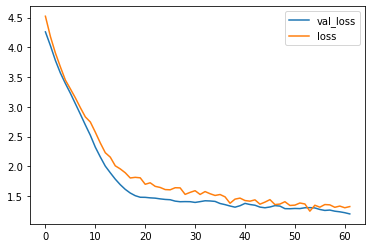

In [85]:
plt.figure(figsize=(6,4))
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['loss'], label='loss')
plt.legend()

In [86]:
np.sqrt(mean_squared_error(np.array(history.history['loss']), (history.history['val_loss'])))

0.1616612347083304

(-0.75, 0.75)

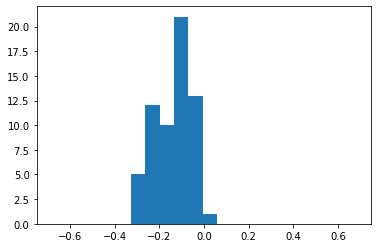

In [87]:
plt.hist((np.array(history.history['val_loss'])-np.array(history.history['loss'])), bins=6)
plt.xlim(-0.75, 0.75)


In [66]:
test_features

,PE,PE_smooth,depth_ft,GR_smooth,DT,RESD,DENS,PHID,GR
1841,0.174202,0.175800,10274.0,0.052938,0.352712,2.853995,0.837719,0.403802,0.055921
1921,0.197321,0.195692,10282.0,0.055321,0.277200,3.101704,0.845109,0.378996,0.059730
1971,0.223413,0.230774,10287.0,0.116060,0.029045,3.431391,0.907035,0.237864,0.140116
2011,0.290151,0.291091,10291.0,0.318147,0.434707,0.606880,0.935051,0.158110,0.361764
2041,0.310009,0.308064,10294.0,0.528070,0.452465,-0.104526,0.903663,0.238054,0.530983
2051,0.312445,0.308632,10295.0,0.531335,0.481930,-0.238277,0.915263,0.209926,0.523019
2071,0.306521,0.308986,10297.0,0.619222,0.539745,-0.366139,0.929128,0.172361,0.634848
2081,0.318900,0.317177,10298.0,0.656890,0.472828,-0.350679,0.930727,0.165748,0.664877
2956,0.202146,0.199033,9424.0,0.164293,0.265126,1.386608,0.826576,0.453168,0.170260
2976,0.198724,0.196437,9426.0,0.173427,0.299936,1.272093,0.841707,0.412073,0.177882


In [67]:
test_labels

,He_por,perm_klink_md
1841,8.2,0.038
1921,8.4,0.033
1971,4.1,0.007
2011,7.6,0.033
2041,7.6,0.029
2051,6.7,0.024
2071,1.0,0.001
2081,3.0,0.006
2956,9.3,0.032
2976,4.4,0.011


Collect the results on the test set:

In [88]:
dnn_model.evaluate(test_features, test_labels, verbose=0)

1.173071265220642

## Performance

Now that all the models are trained check the test-set performance and see how they did:

These results match the validation error seen during training.

### Make predictions

Finally, predict have a look at the errors made by the model when making predictions on the test set:

In [89]:
test_predictions = dnn_model.predict(test_features)

In [91]:
test = test_predictions-test_labels.values

In [101]:
np.shape(test.T)

(2, 48)

In [104]:
df = pd.DataFrame(data=test.T, index=["Por","Perm"])
df100 =df.T

In [105]:
df100.describe()

,Por,Perm
count,48.000000,48.000000
mean,0.076617,0.005079
std,1.979348,0.052572
min,-2.790153,-0.337133
25%,-1.056176,0.003126
50%,-0.649106,0.007832
75%,0.056310,0.019743
max,6.316689,0.060563


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 35., 12.]),
 array([-0.337, -0.297, -0.258, -0.218, -0.178, -0.138, -0.099, -0.059,
        -0.019,  0.021,  0.061]),
 <a list of 10 Patch objects>)

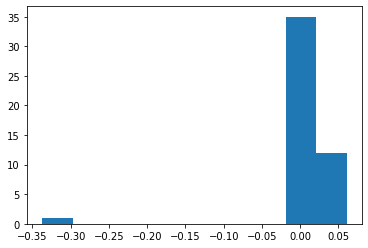

In [106]:
plt.hist(df100.Perm.values)

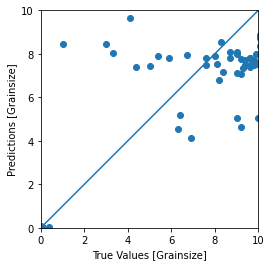

In [46]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Grainsize]')
plt.ylabel('Predictions [Grainsize]')
lims = [0, 10]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


It looks like the model predicts reasonably well. 

Now take a look at the error distribution:

In [47]:
rmse5 = np.sqrt(mean_squared_error(test_labels[0], test_predictions[0]))
print("Mean Squared Error: %f" % (rmse5))
max5 = np.sqrt(max_error(test_labels[0], test_predictions[0]))
print("Max Error: %f" % (max5))

KeyError: ignored

In [48]:
test_predictions

array([ 6.778,  0.052,  7.181,  0.04 ,  9.629, -0.03 ,  7.49 ,  0.05 ,
        7.797,  0.028,  7.947,  0.028,  8.455,  0.029,  8.441,  0.007,
        7.372,  0.037,  7.382,  0.048,  7.7  ,  0.048,  7.118,  0.05 ,
        7.532,  0.037,  7.448,  0.037,  8.103,  0.042,  7.482,  0.047,
        7.396,  0.042,  7.054,  0.046,  7.997,  0.034,  7.911,  0.056,
        7.818,  0.057,  8.102,  0.042,  7.795,  0.017,  7.802,  0.022,
        9.112, -0.041,  7.473,  0.02 ,  8.649, -0.051,  7.72 ,  0.044,
        8.723, -0.023,  7.823, -0.002,  8.03 , -0.023,  8.123, -0.028,
        7.777,  0.029,  7.499, -0.004,  8.351, -0.047,  7.542,  0.005,
        7.988, -0.028,  8.848, -0.027,  7.809, -0.023,  8.535, -0.005,
        4.633,  0.009,  4.126,  0.03 ,  5.186,  0.021,  4.549,  0.016,
        5.051,  0.059,  5.061,  0.056,  7.495,  0.067,  7.899, -0.018],
      dtype=float32)

In [49]:
error = test_predictions - test_labels
plt.hist(error, bins=28)
plt.xlabel('Prediction Error Grainsize')
plt.xlim((-6,6))

ValueError: ignored

If you're happy with the model save it for later use:

In [ ]:
dnn_model.save('dnn_model.h5')

If you reload the model, it gives identical output:

In [ ]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)